In [1]:
from PertMain2 import Pert, Activity
import copy
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def pairsDetection(pertModel):
    graph = pertModel.returnGraph()
    pairs = []
    for node in graph:
        if pertModel.returnNumberSucc(node)==1:
            successor = pertModel.returnSuccList(node)[0]
            if pertModel.returnNumberPred(successor)==1:
                pairs.append((node,successor))
    return pairs


In [3]:

start = Activity("start", 5)
a = Activity("a", 2)
b = Activity("b", 3)
c = Activity("c", 3)
#d = Activity("d", 7)
d = Activity("d", 4)
e = Activity("e", 3)
f = Activity("f", 6)
end = Activity("end", 2)
#graph = {start: [a, d, f], a: [b], b: [c], c: [end], d: [end], f:[end], end:[]}
graph = {start: [a, d, f], a: [b], b: [c], c: [end], d: [e], e: [end], f:[end], end:[]}

pert = Pert(graph)

pert.returnGraphSymbolic()


{'start': ['a', 'd', 'f'],
 'a': ['b'],
 'b': ['c'],
 'c': ['end'],
 'd': ['e'],
 'e': ['end'],
 'f': ['end'],
 'end': []}

In [4]:
listPairs = pairsDetection(pert)
for pair in listPairs:
    print(pair[0].returnName(),pair[1].returnName())

a b
b c
d e


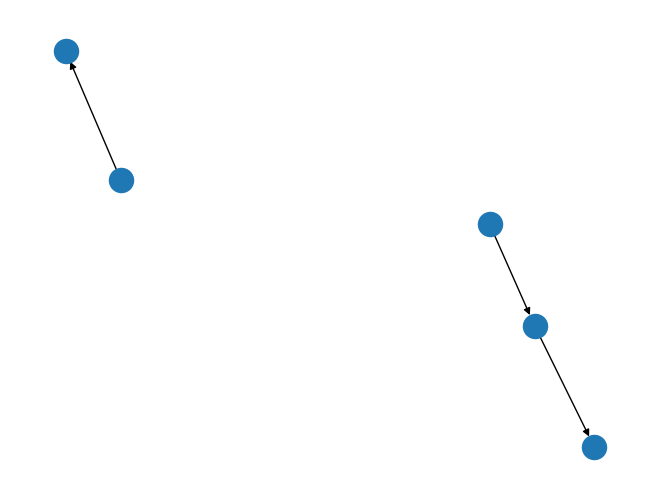

In [5]:
G = nx.DiGraph()
G.add_edges_from(listPairs)
nx.draw(G) 

In [6]:
UG = G.to_undirected()
A = (UG.subgraph(c) for c in nx.connected_components(UG))
listSeries = list(A)

for series in listSeries:
    for elem in list(series.nodes):
        print(elem.name)

a
b
c
e
d


In [7]:
def graph_partitioning(G, plotting=True):
    """Partition a directed graph into a list of subgraphs that contain
    only entirely supported or entirely unsupported nodes.
    """
    # Categorize nodes by their node_type attribute
    supported_nodes = {n for n, d in G.nodes(data="node_type") if d == "supported"}
    unsupported_nodes = {n for n, d in G.nodes(data="node_type") if d == "unsupported"}

    # Make a copy of the graph.
    H = G.copy()
    # Remove all edges connecting supported and unsupported nodes.
    H.remove_edges_from(
        (n, nbr, d)
        for n, nbrs in G.adj.items()
        if n in supported_nodes
        for nbr, d in nbrs.items()
        if nbr in unsupported_nodes
    )
    H.remove_edges_from(
        (n, nbr, d)
        for n, nbrs in G.adj.items()
        if n in unsupported_nodes
        for nbr, d in nbrs.items()
        if nbr in supported_nodes
    )

    # Collect all removed edges for reconstruction.
    G_minus_H = nx.DiGraph()
    G_minus_H.add_edges_from(set(G.edges) - set(H.edges))

    if plotting:
        # Plot the stripped graph with the edges removed.
        _node_colors = [c for _, c in H.nodes(data="node_color")]
        _pos = nx.spring_layout(H)
        plt.figure(figsize=(8, 8))
        nx.draw_networkx_edges(H, _pos, alpha=0.3, edge_color="k")
        nx.draw_networkx_nodes(H, _pos, node_color=_node_colors)
        nx.draw_networkx_labels(H, _pos, font_size=14)
        plt.axis("off")
        plt.title("The stripped graph with the edges removed.")
        plt.show()
        # Plot the edges removed.
        _pos = nx.spring_layout(G_minus_H)
        plt.figure(figsize=(8, 8))
        ncl = [G.nodes[n]["node_color"] for n in G_minus_H.nodes]
        nx.draw_networkx_edges(G_minus_H, _pos, alpha=0.3, edge_color="k")
        nx.draw_networkx_nodes(G_minus_H, _pos, node_color=ncl)
        nx.draw_networkx_labels(G_minus_H, _pos, font_size=14)
        plt.axis("off")
        plt.title("The removed edges.")
        plt.show()

    # Find the connected components in the stripped undirected graph.
    # And use the sets, specifying the components, to partition
    # the original directed graph into a list of directed subgraphs
    # that contain only entirely supported or entirely unsupported nodes.
    subgraphs = [
        H.subgraph(c).copy() for c in nx.connected_components(H.to_undirected())
    ]

    return subgraphs, G_minus_H

subgraphs_of_G_ex, removed_edges = graph_partitioning(G, plotting=False)

listSeries = list(subgraphs_of_G_ex)

for series in listSeries:
    temp = list(nx.topological_sort(series))
    print(temp[0].name, temp[-1].name)

a c
d e


In [8]:
def checkGraph(graph):
    symbGraph = {}
    for key in graph.keys():
        symbGraph[key.returnName()] = []
        for elem in graph[key]:
            symbGraph[key.returnName()].append(elem.returnName())
    print(symbGraph)

In [9]:
originalGraph = copy.deepcopy(graph)
for series in listSeries:
    temp = list(nx.topological_sort(series))
    predOFSeries = pert.returnPredList(temp[0])[0]
    succOFSeries = pert.returnSuccList(temp[-1])
    for node in list(series.nodes):
        del graph[node]
    graph[temp[0]] = succOFSeries

pertSimple = Pert(graph)
pertSimple.returnGraphSymbolic()

{'start': ['a', 'd', 'f'], 'f': ['end'], 'end': [], 'a': ['end'], 'd': ['end']}

In [10]:
def simplifyGraph(pertGraph):
    updatedGraph = copy.deepcopy(pertGraph)
    listPairs = pairsDetection(updatedGraph)

    G = nx.DiGraph()
    G.add_edges_from(listPairs)

    UG = G.to_undirected()
    A = (UG.subgraph(c) for c in nx.connected_components(UG))
    listSeries = list(A)

    for series in listSeries:
        temp = list(nx.topological_sort(series))
        predOFSeries = updatedGraph.returnPredList(temp[0])[0]
        succOFSeries = updatedGraph.returnSuccList(temp[-1])
        for node in list(series.nodes):
            del graph[node]
        updatedGraph[temp[0]] = succOFSeries

    return updatedGraph.returnGraphSymbolic()

simplifyGraph(pert)

{'start': ['a', 'd', 'f'], 'f': ['end'], 'end': [], 'a': ['end'], 'd': ['end']}

In [12]:
pertRed = pert.simplifyGraph()
pertRed.returnGraphSymbolic()

{'start': ['a', 'd', 'f'], 'f': ['end'], 'end': [], 'a': ['end'], 'd': ['end']}